In [125]:
from zipfile import ZipFile
import pandas as pd
from urllib import urlopen
from StringIO import StringIO
import matplotlib.pylab as plt

import seaborn
%pylab inline


Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample', 'plt', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [126]:
# function used to get a df of data on nypd sqf data
def unzip_read_file(year):
    url = urlopen("http://www.nyc.gov/html/nypd/downloads/zip/analysis_and_planning/{}_sqf_csv.zip".format(year))
    zipfile = ZipFile(StringIO(url.read()))
    try:
        with zipfile.open("{}.csv".format(year)) as file:
            df = pd.read_csv(file)
            
    except: # 2015 csv name is different format than all the rest...go figure.
        with zipfile.open("{}_sqf_csv.csv".format(year)) as file:
            df = pd.read_csv(file)
    return df

# Cleans dates formatted without leading zero for months 1-9
def make_date(date_string):
    if len(date_string)<8:
        date_string = '0'+date_string
    return date_string

In [127]:
d = {'Y': True, 'N': False}
r = {'A': 'ASIAN/PACIFIC ISLANDER', 'B': 'BLACK', 'I': 'AMERICAN INDIAN/ALASKAN NATIVE',
     'P': 'BLACK-HISPANIC', 'Q': 'WHITE-HISPANIC', 'W': 'WHITE', 'U': 'UNKNOWN', 
     'X': 'UNKNOWN', 'Z': 'OTHER'}

In [128]:
df = pd.DataFrame()

In [129]:
try:
    master_df = pd.read_csv('master_df.csv')
except:
    master_df = pd.DataFrame()
    for year in range(2003, 2016):

        year_df = unzip_read_file(year)
        year_df.rename(columns={'adrnum': 'addrnum', 'adrpct': 'addrpct', 'detailcm': 'detailCM', 
                                'dettyp_c': 'dettypCM', 'dettypcm': 'dettypCM', 'linecm': 'lineCM', 
                                'premtyp': 'premtype', 'prenam': 'prename', 'rescod': 'rescode',
                                'stinter': 'strintr', 'stname': 'strname'}, inplace=True)
        if len(list(year_df.columns)) != len(set(list(year_df.columns))):
            print sorted(list(year_df.columns))
        print year

        year_df['datestop'] = year_df['datestop'].astype(str).apply(make_date)
        year_df = year_df[~year_df['datestop'].isin(['0', '0 '])]
        try:
            year_df.datestop = pd.to_datetime(year_df.datestop, format='%m%d%Y')
        except:
            year_df.datestop = pd.to_datetime(year_df.datestop, format='%Y-%m-%d')

        year_df['race'] = year_df['race'].replace(r)
        year_df['arstmade'] = year_df['arstmade'].replace(d)

        table_date = pd.pivot_table(year_df, values='year', index=['pct', 'datestop', 'race'], 
                                    columns='arstmade', aggfunc= 'count')

        table_date.fillna(0, inplace=True)

        table_date['Count'] = table_date[False] + table_date[True]
        table_date['Success_Rate'] = table_date[True] / table_date['Count']



        master_df = master_df.append(table_date)
    
    master_df.to_csv('master_df.csv')
    master_df.reset_index(inplace=True)

In [130]:
master_df = master_df.iloc[:,:5]

#grab the clean data
master_df = master_df[(master_df['datestop'] > '2000-01-01') & (master_df['pct'] != 999) & (master_df['race'] != ' ')]

# Aggregation by date
date_df = master_df.iloc[:,[1,3,4]].groupby('datestop').sum()

# Aggregation by race and date
print master_df.columns[1:5].tolist()
race_date_df = master_df.iloc[:,[1,2,3,4]].groupby(['datestop', 'race']).sum()

# Aggregation by pct and date
print master_df.columns[[0,1,3,4]].tolist()
pct_date_df = master_df.iloc[:,[0,1,3,4]].groupby(['pct', 'datestop']).sum()

# Aggregation by pct
print master_df.columns[[0,3,4]].tolist()
pct_df = master_df.iloc[:,[0,3,4]].groupby('pct').sum()

# Agg. by race
print master_df.columns[2:5].tolist()
race_df = master_df.iloc[:,[2,3,4]].groupby('race').sum()

# Agg. by race and pct
race_pct_df = master_df.iloc[:,[0,2,3,4]].groupby(['race', 'pct']).sum()

['datestop', 'race', 'False', 'True']
['pct', 'datestop', 'False', 'True']
['pct', 'False', 'True']
['race', 'False', 'True']


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:56: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

AMERICAN INDIAN/ALASKAN NATIVE
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.029181
SUCCESS_RATE -0.029181      1.000000
WHITE-HISPANIC
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.481047
SUCCESS_RATE -0.481047      1.000000
UNKNOWN
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.065984
SUCCESS_RATE -0.065984      1.000000
ASIAN/PACIFIC ISLANDER
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.124573
SUCCESS_RATE -0.124573      1.000000
BLACK-HISPANIC
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.336612
SUCCESS_RATE -0.336612      1.000000
OTHER
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.212995
SUCCESS_RATE -0.212995      1.000000
BLACK
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.520474
SUCCESS_RATE -0.520474      1.000000
WHITE
                 COUNT  SUCCESS_RATE
COUNT         1.000000     -0.298553
SUCCESS_RATE -0.298553      1.000000


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

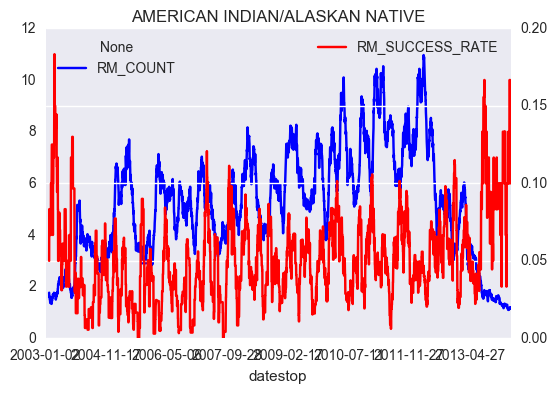

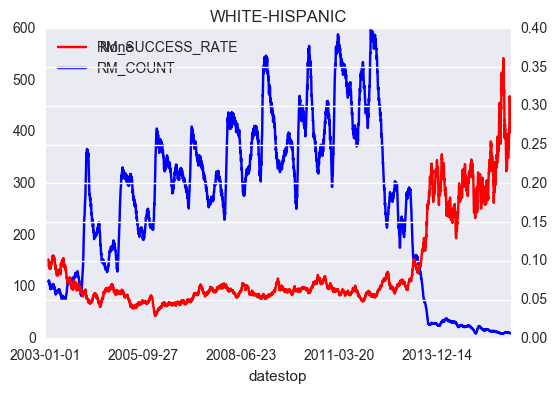

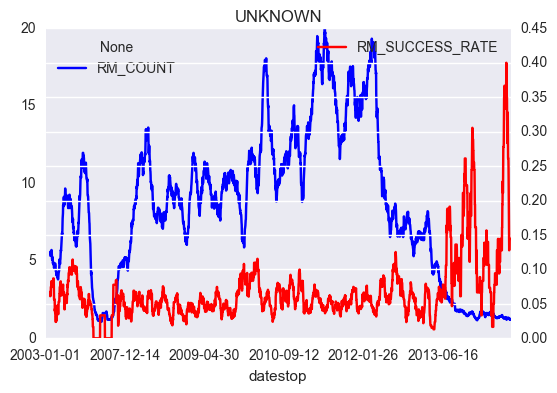

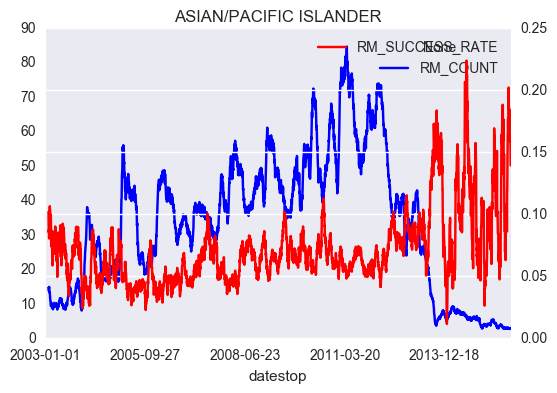

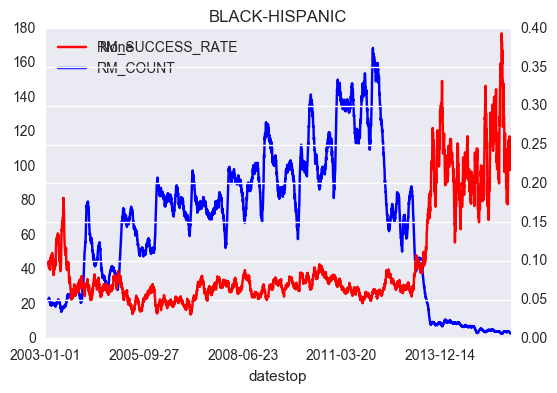

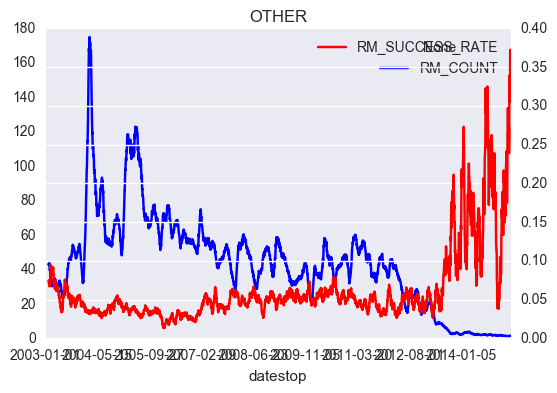

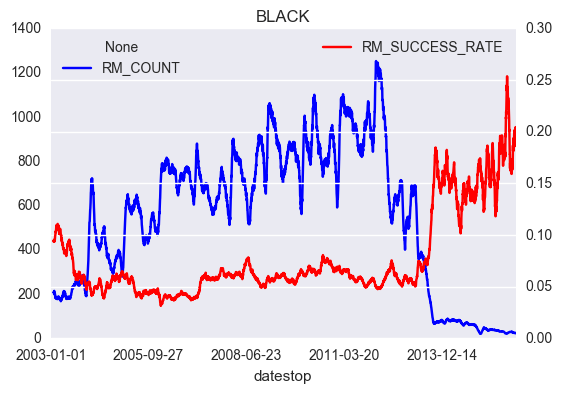

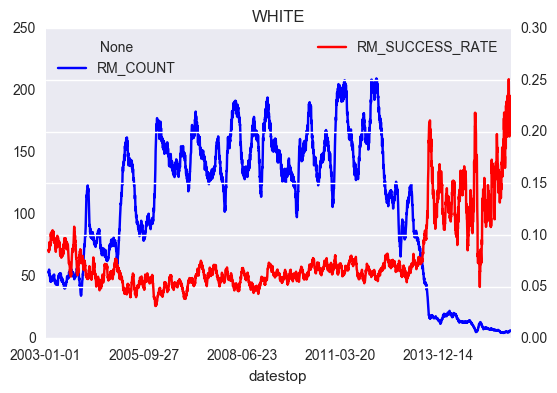

In [131]:
master_df = master_df.iloc[:,:5]

#grab the clean data
master_df = master_df[(master_df['datestop'] > '2000-01-01') & (master_df['pct'] != 999) & (master_df['race'] != ' ')]

# Aggregation by date
date_df = master_df.iloc[:,[1,3,4]].groupby('datestop').sum()

# Aggregation by race and date
#print master_df.columns[1:5].tolist()
race_date_df = master_df.iloc[:,[1,2,3,4]].groupby(['datestop', 'race']).sum()

# Aggregation by pct and date
#print master_df.columns[[0,1,3,4]].tolist()
pct_date_df = master_df.iloc[:,[0,1,3,4]].groupby(['pct', 'datestop']).sum()

# Aggregation by pct
#print master_df.columns[[0,3,4]].tolist()
pct_df = master_df.iloc[:,[0,3,4]].groupby('pct').sum()

# Agg. by race
#print master_df.columns[2:5].tolist()
race_df = master_df.iloc[:,[2,3,4]].groupby('race').sum()

# Agg. by race and pct
race_pct_df = master_df.iloc[:,[0,2,3,4]].groupby(['race', 'pct']).sum()

for i in [date_df, race_date_df, pct_date_df]:#, pct_df, race_df, race_pct_df]:
    i.reset_index(inplace=True)
    cols = list(i.columns)
    cols[-2]='False'
    cols[-1]='True'
    i.columns = cols
    i['COUNT'] = i['True'] + i['False']
    i['SUCCESS_RATE'] = i['True'] / i['COUNT']
    
    
    i.index = i.datestop
    try:            
        for j in list(set(i['race'])):
            temp = i[i['race'] == j]
            temp['RM_COUNT'] = pd.rolling_mean(temp.COUNT, window=30, min_periods=30)
            temp['RM_SUCCESS_RATE'] = pd.rolling_mean(temp.SUCCESS_RATE, window=30, min_periods=30)
            print j
            print temp.loc[:,['COUNT', 'SUCCESS_RATE']].corr()

            plt.figure(); temp['RM_COUNT'].plot(c='b');plt.legend(loc='best'); temp['RM_SUCCESS_RATE'].plot(c='r', secondary_y=True);plt.title(j); plt.legend(loc='best')
    except Exception as e:
        try:
            for j in list(set(i['pct'])):
                temp = i[i['pct'] == j]
                temp['RM_COUNT'] = pd.rolling_mean(temp.COUNT, window=30, min_periods=30)
                temp['RM_SUCCESS_RATE'] = pd.rolling_mean(temp.SUCCESS_RATE, window=30, min_periods=30)
                #plt.figure(); temp['RM_COUNT'].plot(); temp['RM_SUCCESS_RATE'].plot(secondary_y=True);plt.title(j); plt.legend(loc='best')
        except:
            i['RM_COUNT'] = pd.rolling_mean(i.COUNT, window=30, min_periods=30)
            i['RM_SUCCESS_RATE'] = pd.rolling_mean(i.SUCCESS_RATE, window=30, min_periods=30)

            #plt.figure(); i['RM_COUNT'].plot(); i['RM_SUCCESS_RATE'].plot(secondary_y=True); plt.title(str(list(i.columns))); plt.legend(loc='best')


In [132]:
threshold_SR_A = [date_df['SUCCESS_RATE'].mean() + date_df['SUCCESS_RATE'].std()] 
threshold_SR_B = [date_df['SUCCESS_RATE'].mean() - date_df['SUCCESS_RATE'].std()]

threshold_CNT_B = [date_df['COUNT'].mean() -  date_df['COUNT'].std()] 
threshold_CNT_A = [date_df['COUNT'].mean() +  date_df['COUNT'].std()] 

print ("1-sigma threshold SUCCESS_RATE {:.2f}".format(*threshold_SR_A))
print ("1-sigma threshold COUNT {:.2f}".format(*threshold_CNT_A))
# print ("earliest datapoint", min(date_df.index))

1-sigma threshold SUCCESS_RATE 0.13
1-sigma threshold COUNT 1745.51


In [133]:
date_df['COUNT'].mean()

1063.8439342881213

In [134]:
date_df[['RM_COUNT', 'RM_SUCCESS_RATE']].corr()
import scipy.stats  as stats
stats.pearsonr([1, 2, 3], [4, 3, 7])
stats.pearsonr(date_df['RM_COUNT'].dropna(), date_df['RM_SUCCESS_RATE'].dropna())

(-0.75237194794174134, 0.0)

In [135]:
pd.to_datetime(date_df['datestop'])[0]

Timestamp('2003-01-01 00:00:00')

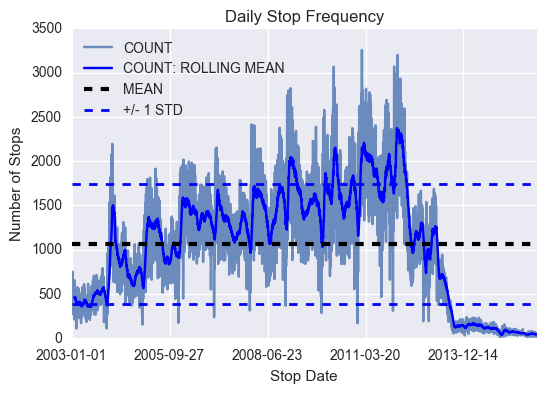

In [136]:
import seaborn
plt.figure();  
ax = date_df['COUNT'].plot(alpha=0.8, label='COUNT'); date_df['RM_COUNT'].plot(color='b', label='COUNT: ROLLING MEAN'); plt.legend(loc='best'); 
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [date_df['COUNT'].mean(), date_df['COUNT'].mean()], ls='--', color="k", lw=3, label='MEAN')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_CNT_A, threshold_CNT_A], ls='--', color="b", lw=2, label='+/- 1 STD')

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_CNT_B, threshold_CNT_B], ls='--', color="b", lw=2)

# ax2 = date_df['SUCCESS_RATE'].plot(color='IndianRed', alpha=0.75, secondary_y=True); date_df['RM_SUCCESS_RATE'].plot(color='r', secondary_y=True)
# ax2.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_SR, threshold_SR], ls='--', color='IndianRed',  lw=3, label='blah')

#plt.plot([min(date_df.index), max(date_df.index)], [threshold_SR, threshold_SR])
plt.title('Daily Stop Frequency'); plt.legend(loc='best')
plt.ylabel('Number of Stops')
plt.xlabel('Stop Date')



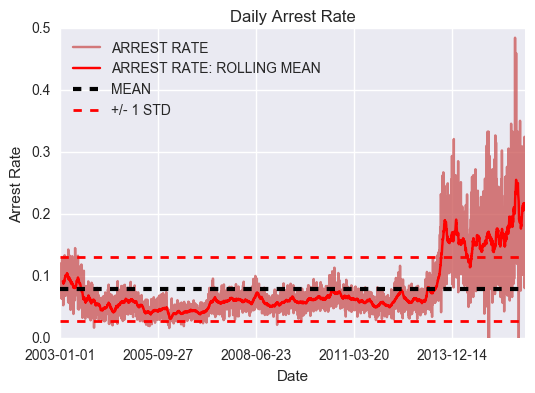

In [167]:
plt.figure();  
ax = date_df['SUCCESS_RATE'].plot(alpha=0.8, color = 'IndianRed', label='ARREST RATE'); date_df['RM_SUCCESS_RATE'].plot(color='r', label='ARREST RATE: ROLLING MEAN'); plt.legend(loc='best'); 
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [date_df['SUCCESS_RATE'].mean(), date_df['SUCCESS_RATE'].mean()], ls='--', color="k", lw=3, label='MEAN')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_SR_A, threshold_SR_A], ls='--', color="r", lw=2, label='+/- 1 STD')

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_SR_B, threshold_SR_B], ls='--', color="r", lw=2)

# ax2 = date_df['SUCCESS_RATE'].plot(color='IndianRed', alpha=0.75, secondary_y=True); date_df['RM_SUCCESS_RATE'].plot(color='r', secondary_y=True)
# ax2.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_SR, threshold_SR], ls='--', color='IndianRed',  lw=3, label='blah')

#plt.plot([min(date_df.index), max(date_df.index)], [threshold_SR, threshold_SR])
plt.title('Daily Arrest Rate'); plt.legend(loc='best')
plt.ylabel('Arrest Rate')
plt.xlabel('Date')


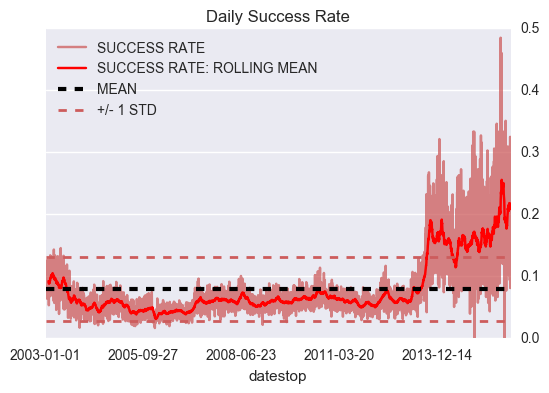

In [138]:
plt.figure()

ax2 = date_df['SUCCESS_RATE'].plot(label='SUCCESS RATE', color='IndianRed', alpha=0.75, secondary_y=True); date_df['RM_SUCCESS_RATE'].plot(label='SUCCESS RATE: ROLLING MEAN', color='r', secondary_y=True)


ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [date_df['SUCCESS_RATE'].mean(), date_df['SUCCESS_RATE'].mean()], ls='--', color="k", lw=3, label='MEAN')
ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [threshold_SR_A, threshold_SR_A], ls='--', color="IndianRed", lw=2, label='+/- 1 STD')
ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [threshold_SR_B, threshold_SR_B], ls='--', color='IndianRed', lw=2)
# threshold_SR_2A = date_df['SUCCESS_RATE'].mean() + 2 * date_df['SUCCESS_RATE'].std()
# ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [threshold_SR_2A, threshold_SR_2A], ls='--', color='IndianRed', lw=3)
plt.title('Daily Success Rate'); 
plt.xlabel('Date')
plt.legend(loc='best');

In [139]:
date_df['YEAR'] = pd.to_datetime(date_df.datestop).map(lambda x: x.year)
date_df['MONTH'] = pd.to_datetime(date_df.datestop).map(lambda x: x.month)

# date_df.loc[(date_df.COUNT>threshold_CNT_B)].groupby(pd.to_datetime(date_df.datestop).map(lambda x: x.year))
date_df.loc[(date_df.COUNT<threshold_CNT_B)][['YEAR', 'MONTH', 'COUNT']].groupby(['YEAR']).count()#.to_csv('count.csv')

,MONTH,COUNT
YEAR,,
2003,114,114
2004,10,10
2005,1,1
2006,1,1
2007,2,2
2008,1,1
2009,1,1
2010,3,3
2011,1,1


In [140]:
date_df.loc[(date_df.COUNT<threshold_CNT_B)][['YEAR', 'MONTH', 'COUNT']].groupby(['YEAR', 'MONTH']).count()#.to_csv('count.csv')

COUNT
YEAR MONTH       
2003 1          9
     2         12
     3         15
     4         12
     5         10
     6         18
     7         10
     8          8
     9          4
     10         1
     11         1
     12        14
2004 8          1
     9          2
     11         1
     12         6
2005 12         1
2006 12         1
2007 12         2
2008 12         1
2009 12         1
2010 12         3
2011 12         1
2012 10         1
     12         2
2013 3          1
     6          1
     7         17
     8         31
     9         30
     10        31
     11        30
     12        31
2014 1         31
     2         28
     3         31
     4         30
     5         31
     6         30
     7         31
     8         31
     9         30
     10        31
     11        30
     12        31
2015 1         31
     2         28
     3         31
     4         30
     5         31
     6         30
     7         31
     8         31
     9         30
     10        31
     11        30
     12        31

In [141]:
date_df.loc[(date_df.SUCCESS_RATE>threshold_SR_A)][['YEAR', 'MONTH', 'SUCCESS_RATE']].groupby(['YEAR']).count()#.to_csv('success_rate.csv')

,MONTH,SUCCESS_RATE
YEAR,,
2003,7,7
2013,115,115
2014,235,235
2015,276,276


In [142]:
date_df.loc[(date_df.SUCCESS_RATE>threshold_SR_A)][['YEAR', 'MONTH', 'SUCCESS_RATE']].groupby(['YEAR', 'MONTH']).count()#.to_csv('success_rate.csv')

SUCCESS_RATE
YEAR MONTH              
2003 2                 2
     3                 1
     4                 1
     5                 1
     6                 1
     7                 1
2013 7                 1
     8                17
     9                28
     10               24
     11               23
     12               22
2014 1                25
     2                20
     3                28
     4                18
     5                11
     6                15
     7                20
     8                21
     9                17
     10               19
     11               19
     12               22
2015 1                21
     2                17
     3                20
     4                20
     5                22
     6                19
     7                24
     8                28
     9                28
     10               24
     11               27
     12               26

In [143]:
print ("mean success rate by day {:.3f}".format(date_df['SUCCESS_RATE'].mean()*100))
print ("stdev success rate by day {:.3f}\n".format(date_df['SUCCESS_RATE'].std()*100))

print ("mean count by day {:.3f}".format(date_df['COUNT'].mean()))
print ("stdev count by day {:.3f}".format(date_df['COUNT'].std()))

mean success rate by day 7.953
stdev success rate by day 5.135

mean count by day 1063.844
stdev count by day 681.669


In [144]:
date_df['SUCCESS_RATE'].mean()*100+date_df['SUCCESS_RATE'].std()*100

13.088319747712255

In [145]:
import scipy.stats as stats
sample1 = date_df[date_df['datestop'] >= '2013-08-12']['COUNT']
sample2 = date_df[date_df['datestop'] < '2013-08-12']['COUNT']
t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
print t_stat,p_val


-129.043428721 0.0


In [146]:
sample1 = date_df[date_df['datestop'] >= '2013-08-12']['SUCCESS_RATE']
sample2 = date_df[date_df['datestop'] < '2013-08-12']['SUCCESS_RATE']
t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
print t_stat,p_val

52.9034776519 2.58116742402e-279


In [147]:
# date_df[date_df['datestop'] >= '2013-08-12']['SUCCESS_RATE']
mean(date_df[date_df['datestop'] > '2013-08-12']['SUCCESS_RATE'])

0.16737260212915622

In [148]:
print date_df[date_df['datestop'] >= '2013-08-12']['SUCCESS_RATE'].mean(), date_df[date_df['datestop'] >= '2013-08-12']['SUCCESS_RATE'].std()
print date_df[date_df['datestop'] < '2013-08-12']['SUCCESS_RATE'].mean(), date_df[date_df['datestop'] < '2013-08-12']['SUCCESS_RATE'].std()

0.167300474847 0.0594212186606
0.0597886008991 0.0176937090375


In [149]:
print date_df[date_df['datestop'] >= '2013-08-12']['COUNT'].mean(), date_df[date_df['datestop'] >= '2013-08-12']['COUNT'].std()
print date_df[date_df['datestop'] < '2013-08-12']['COUNT'].mean(), date_df[date_df['datestop'] < '2013-08-12']['COUNT'].std()

100.587155963 50.1474447834
1280.55185759 559.374940695


In [150]:
314./872

0.36009174311926606

In [151]:
date_df[['COUNT',"YEAR"]].groupby('YEAR').sum().reset_index()

,YEAR,COUNT
0,2003,160574.0
1,2004,313041.0
2,2005,397390.0
3,2006,506457.0
4,2007,472079.0
5,2008,540301.0
6,2009,581168.0
7,2010,601285.0
8,2011,685724.0
9,2012,532911.0


In [152]:
len(date_df.loc[(date_df.COUNT<threshold_CNT_B) & (date_df.datestop>='2013-08-12')][['YEAR', 'MONTH', 'SUCCESS_RATE']])
# len(date_df.loc[(date_df.datestop<'2013-08-12')][['YEAR', 'MONTH', 'SUCCESS_RATE']])


872

In [153]:
print len(date_df.loc[(date_df.datestop<'2013-08-12')])
print len(date_df.loc[(date_df.COUNT<threshold_CNT_B) & (date_df.datestop<'2013-08-12')])#[['YEAR', 'MONTH', 'SUCCESS_RATE']].groupby(['YEAR', 'MONTH']).count()#.to_csv('success_rate.csv')
print len(date_df.loc[(date_df.COUNT<threshold_CNT_B) & (date_df.datestop<'2013-08-12')])

3876
167
167


In [154]:
167./3876

0.043085655314757484

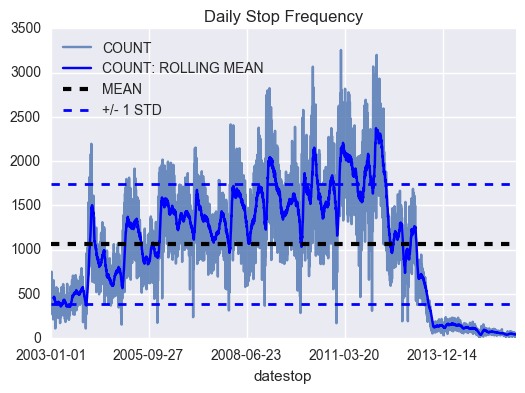

In [155]:
plt.figure();  
ax = date_df['COUNT'].plot(alpha=0.8, label='COUNT'); date_df['RM_COUNT'].plot(color='b', label='COUNT: ROLLING MEAN'); plt.legend(loc='best'); 
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [date_df['COUNT'].mean(), date_df['COUNT'].mean()], ls='--', color="k", lw=3, label='MEAN')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_CNT_A, threshold_CNT_A], ls='--', color="b", lw=2, label='+/- 1 STD')

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_CNT_B, threshold_CNT_B], ls='--', color="b", lw=2)

# ax2 = date_df['SUCCESS_RATE'].plot(color='IndianRed', alpha=0.75, secondary_y=True); date_df['RM_SUCCESS_RATE'].plot(color='r', secondary_y=True)
# ax2.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_SR, threshold_SR], ls='--', color='IndianRed',  lw=3, label='blah')

#plt.plot([min(date_df.index), max(date_df.index)], [threshold_SR, threshold_SR])
plt.title('Daily Stop Frequency'); plt.legend(loc='best')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

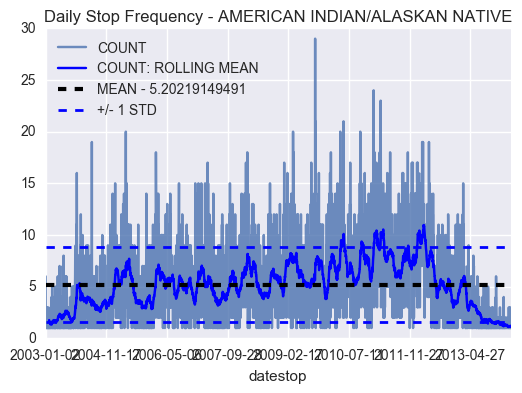

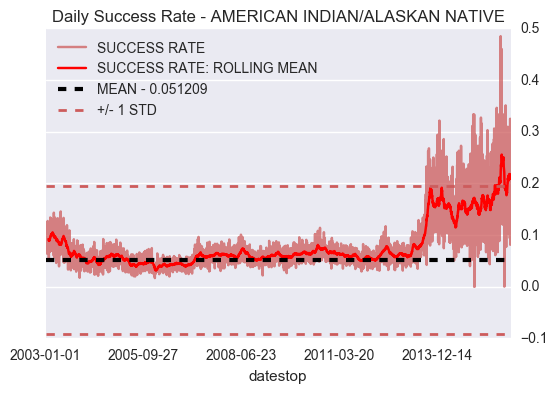

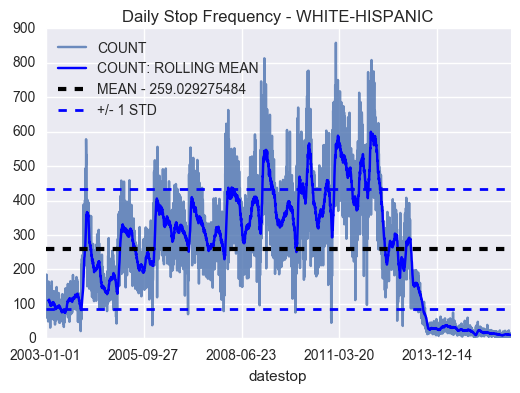

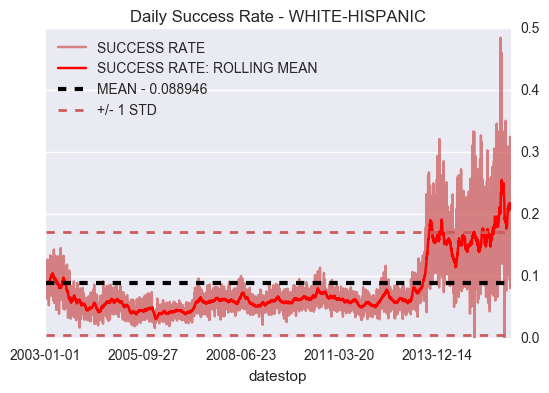

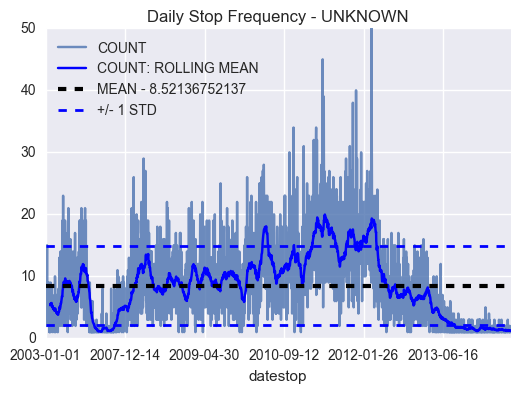

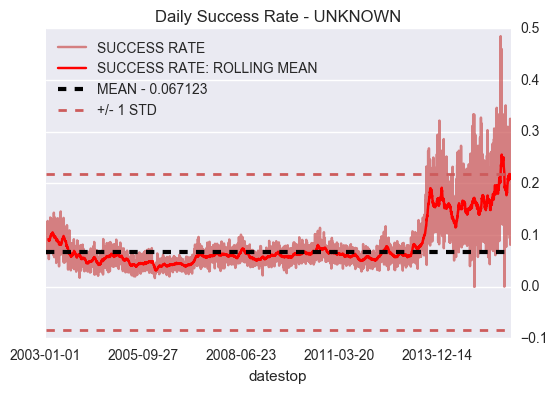

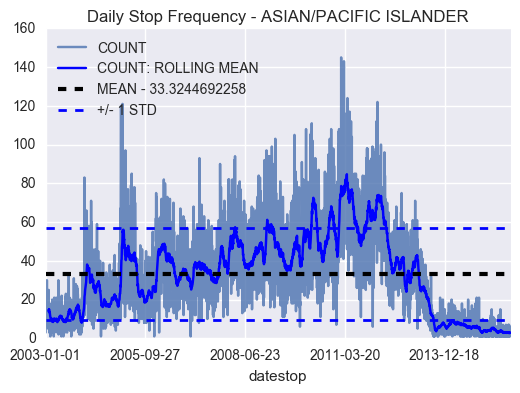

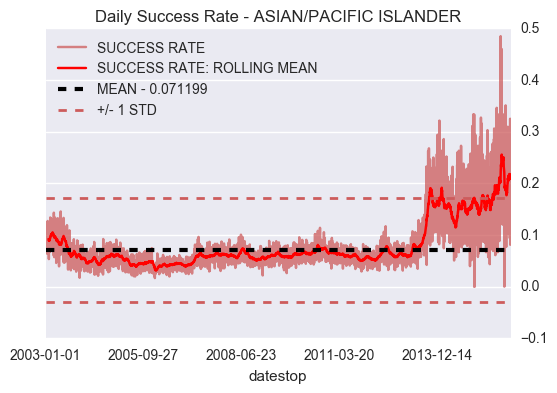

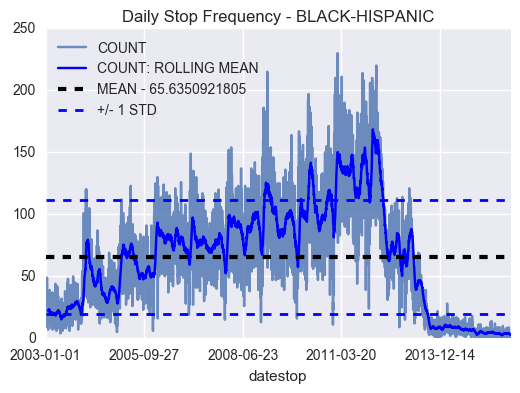

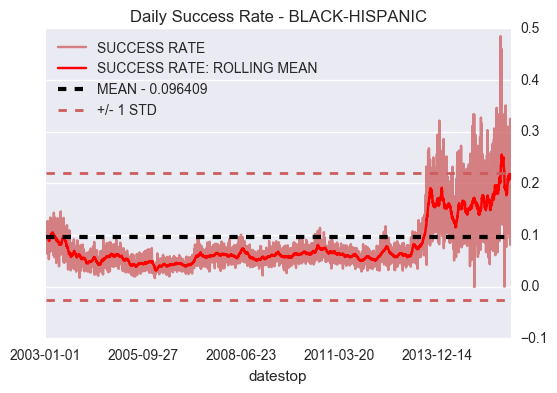

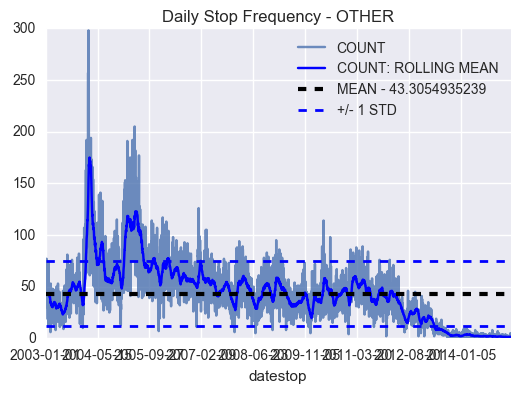

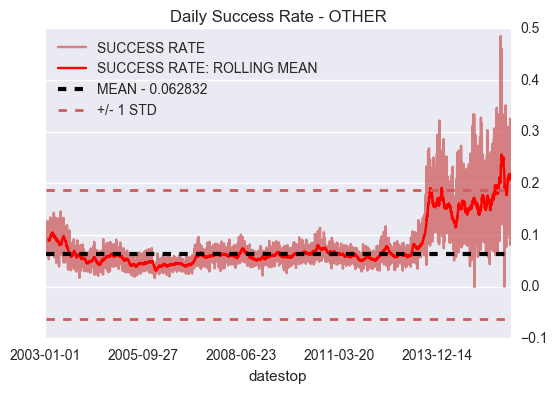

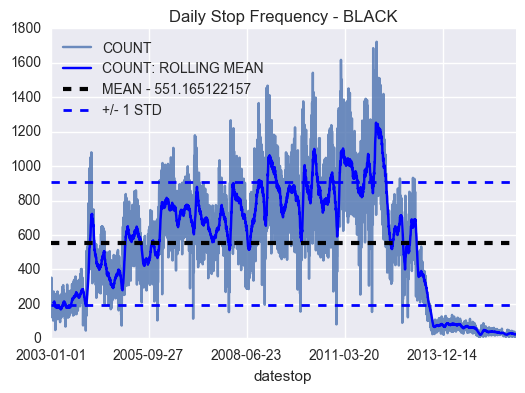

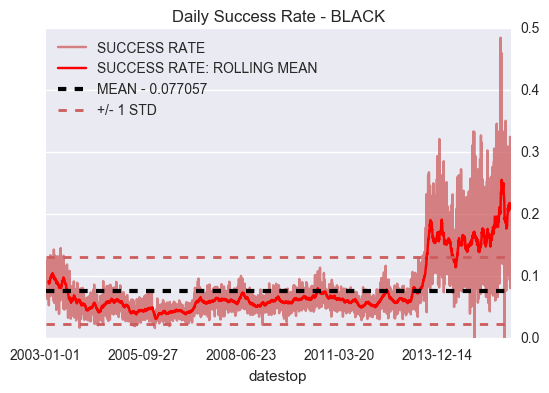

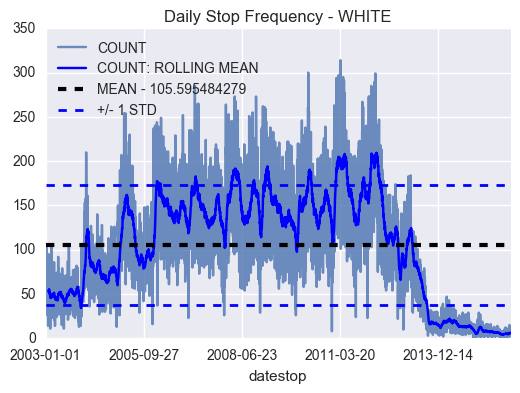

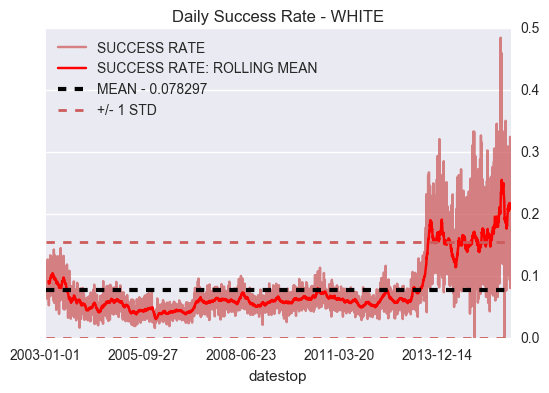

In [156]:
suc_rate_tt = []
cnt_tt = []

for j in list(set(race_date_df['race'])):
    temp = race_date_df[race_date_df['race'] == j]
    temp['RM_COUNT'] = pd.rolling_mean(temp.COUNT, window=30, min_periods=30)
    temp['RM_SUCCESS_RATE'] = pd.rolling_mean(temp.SUCCESS_RATE, window=30, min_periods=30)
#     #print temp.loc[:,['COUNT', 'SUCCESS_RATE']].corr()

#     plt.figure(); temp['RM_COUNT'].plot(); temp['RM_SUCCESS_RATE'].plot(secondary_y=True);plt.title(j); plt.legend(loc='best')
    plt.figure();
    temp_threshold_SR_A = [temp['SUCCESS_RATE'].mean() + temp['SUCCESS_RATE'].std()] 
    temp_threshold_SR_B = [temp['SUCCESS_RATE'].mean() - temp['SUCCESS_RATE'].std()]

    temp_threshold_CNT_B = [temp['COUNT'].mean() -  temp['COUNT'].std()] 
    temp_threshold_CNT_A = [temp['COUNT'].mean() +  temp['COUNT'].std()]
    ax = temp['COUNT'].plot(alpha=0.8, label='COUNT'); temp['RM_COUNT'].plot(color='b', label='COUNT: ROLLING MEAN'); plt.legend(loc='best'); 
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [temp['COUNT'].mean(), temp['COUNT'].mean()], ls='--', color="k", lw=3, label='MEAN - %s' % str(temp['COUNT'].mean()))
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [temp_threshold_CNT_A, temp_threshold_CNT_A], ls='--', color="b", lw=2, label='+/- 1 STD')

    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [temp_threshold_CNT_B, temp_threshold_CNT_B], ls='--', color="b", lw=2)

    # ax2 = date_df['SUCCESS_RATE'].plot(color='IndianRed', alpha=0.75, secondary_y=True); date_df['RM_SUCCESS_RATE'].plot(color='r', secondary_y=True)
    # ax2.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [threshold_SR, threshold_SR], ls='--', color='IndianRed',  lw=3, label='blah')

    #plt.plot([min(date_df.index), max(date_df.index)], [threshold_SR, threshold_SR])
    plt.title('Daily Stop Frequency - %s' % j); plt.legend(loc='best')
    
    plt.figure(); 

    ax2 = date_df['SUCCESS_RATE'].plot(label='SUCCESS RATE', color='IndianRed', alpha=0.75, secondary_y=True); date_df['RM_SUCCESS_RATE'].plot(label='SUCCESS RATE: ROLLING MEAN', color='r', secondary_y=True)


    ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [temp['SUCCESS_RATE'].mean(), temp['SUCCESS_RATE'].mean()], ls='--', color="k", lw=3, label='MEAN - %f' % temp['SUCCESS_RATE'].mean())
    ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [temp_threshold_SR_A, temp_threshold_SR_A], ls='--', color="IndianRed", lw=2, label='+/- 1 STD')
    ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [temp_threshold_SR_B, temp_threshold_SR_B], ls='--', color='IndianRed', lw=2)
    # threshold_SR_2A = date_df['SUCCESS_RATE'].mean() + 2 * date_df['SUCCESS_RATE'].std()
    # ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [threshold_SR_2A, threshold_SR_2A], ls='--', color='IndianRed', lw=3)
    plt.legend(loc='best'); plt.title('Daily Success Rate - %s' % j)
    sample1 = temp[temp['datestop'] >= '2013-08-12']['SUCCESS_RATE']
    sample2 = temp[temp['datestop'] < '2013-08-12']['SUCCESS_RATE']
    t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
    suc_rate_tt.append([j,temp['SUCCESS_RATE'].mean(),temp['SUCCESS_RATE'].std(),t_stat,p_val])
    sample1 = temp[temp['datestop'] >= '2013-08-12']['COUNT']
    sample2 = temp[temp['datestop'] < '2013-08-12']['COUNT']
    t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
    cnt_tt.append([j, temp['COUNT'].mean(),temp['SUCCESS_RATE'].std(), t_stat,p_val])

In [157]:
pd.merge(pd.DataFrame(suc_rate_tt, columns=['race','mean', 'St.Dev', 't-statistic', 'p-value']),pd.DataFrame(cnt_tt, columns=['race','mean', 'St.Dev', 't-statistic', 'p-value']),how='inner', on='race')

,race,mean_x,St.Dev_x,t-statistic_x,p-value_x,mean_y,St.Dev_y,t-statistic_y,p-value_y
0,AMERICAN INDIAN/ALASKAN NATIVE,0.051209,0.143396,3.184016,1.631141e-03,5.202191,0.143396,-49.485808,7.206952e-287
1,WHITE-HISPANIC,0.088946,0.082927,32.325004,4.907973e-152,259.029275,0.082927,-120.578255,0.000000e+00
2,UNKNOWN,0.067123,0.150657,5.442823,9.337500e-08,8.521368,0.150657,-62.165519,0.000000e+00
3,ASIAN/PACIFIC ISLANDER,0.071199,0.100494,6.480450,1.578455e-10,33.324469,0.100494,-88.823863,0.000000e+00
4,BLACK-HISPANIC,0.096409,0.122829,20.166883,2.545816e-74,65.635092,0.122829,-108.977704,0.000000e+00
5,OTHER,0.062832,0.125070,10.105972,2.719243e-22,43.305494,0.125070,-99.935607,0.000000e+00
6,BLACK,0.077057,0.053420,39.165636,1.257230e-196,551.165122,0.053420,-126.621553,0.000000e+00
7,WHITE,0.078297,0.077365,15.747159,2.084828e-49,105.595484,0.077365,-119.853556,0.000000e+00


In [158]:
suc_rate_tt

[['AMERICAN INDIAN/ALASKAN NATIVE',
  0.051209199069768827,
  0.14339574671910885,
  3.1840155871766536,
  0.001631141308875378],
 ['WHITE-HISPANIC',
  0.08894645000294114,
  0.08292723904079012,
  32.325003754553926,
  4.9079729187987747e-152],
 ['UNKNOWN',
  0.06712259546593602,
  0.1506571658978526,
  5.4428228783452015,
  9.3374997030022927e-08],
 ['ASIAN/PACIFIC ISLANDER',
  0.07119917386683514,
  0.10049350296421175,
  6.4804497612669767,
  1.5784549433629576e-10],
 ['BLACK-HISPANIC',
  0.09640914070337471,
  0.12282852819198072,
  20.166882737791788,
  2.5458155940388152e-74],
 ['OTHER',
  0.06283210654841317,
  0.12506966753632012,
  10.105971582217947,
  2.719242739162575e-22],
 ['BLACK',
  0.07705730811641744,
  0.05342030223279362,
  39.165635983478559,
  1.2572303486769615e-196],
 ['WHITE',
  0.0782972349241953,
  0.0773654228155962,
  15.747159274381833,
  2.0848281223154473e-49]]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
  from ipykernel import kernelapp as app


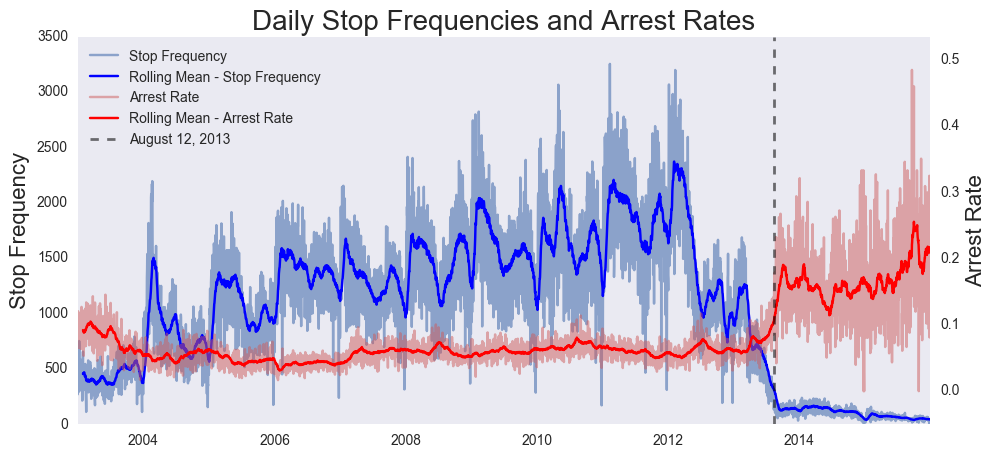

In [162]:
date_df['RM_COUNT'] = pd.rolling_mean(date_df.COUNT, window=30, min_periods=30)
date_df['RM_SUCCESS_RATE'] = pd.rolling_mean(date_df.SUCCESS_RATE, window=30, min_periods=30)
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(111)
lns1 = ax.plot(pd.to_datetime(date_df['datestop']), date_df['COUNT'], alpha=0.6, label='Stop Frequency')
lns2 = ax.plot(pd.to_datetime(date_df['datestop']), date_df['RM_COUNT'], c='b', label='Rolling Mean - Stop Frequency')
#ax.plot(0, 0, '-r', label = 'Rolling Mean - Success Rate')
ax.grid(False)

ax2 = ax.twinx()
lns3 = ax2.plot(pd.to_datetime(date_df['datestop']), date_df['SUCCESS_RATE'], alpha=0.5, c='IndianRed', label = 'Arrest Rate')
lns4 = ax2.plot(pd.to_datetime(date_df['datestop']), date_df['RM_SUCCESS_RATE'], c='r', label = 'Rolling Mean - Arrest Rate')
lns5 = ax2.axvline(x=pd.to_datetime('2013-08-12'), ymin=0, ymax = 1, ls='dashed', alpha=0.55, linewidth=2, color='k', label='August 12, 2013')
ax2.set_ylim(min(date_df['SUCCESS_RATE'])-0.05, max(date_df['SUCCESS_RATE'])+0.05)
ax2.grid(False)
lns = lns1+lns2+lns3+lns4
lns.append(lns5)
labs = [l.get_label() for l in lns]

if idx==0:
    ax.legend(lns, labs, loc=9)
else:
    ax.legend(lns, labs, loc=2)
ax.set_title('Daily Stop Frequencies and Arrest Rates', size=20)
ax.set_ylabel('Stop Frequency', size=16)

ax2.set_ylabel('Arrest Rate', size=16)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=30,window=30,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

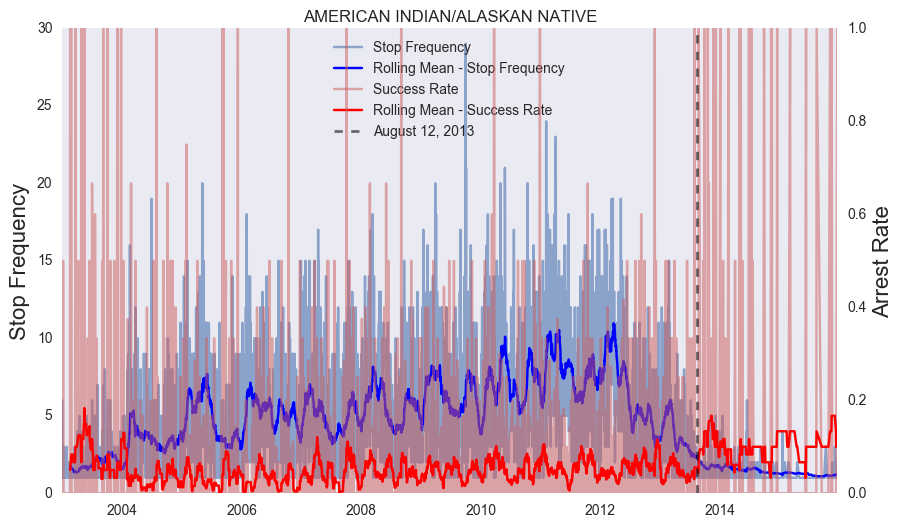

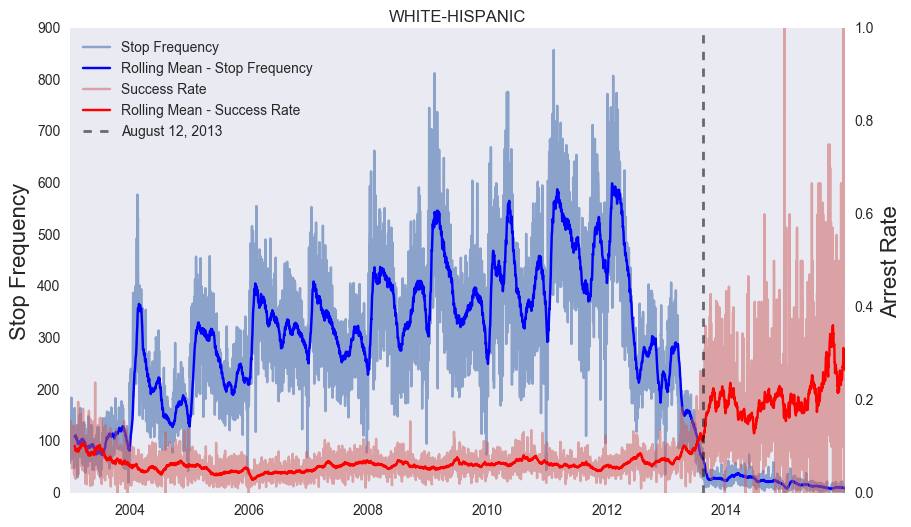

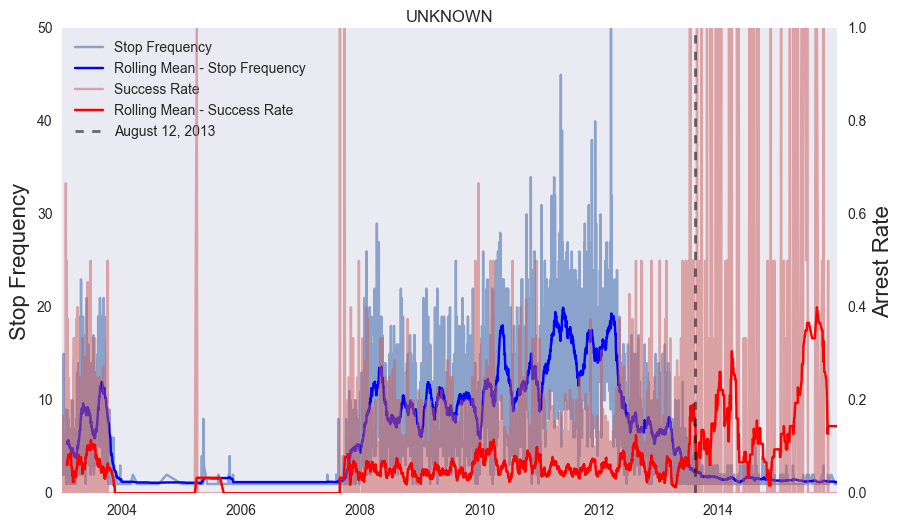

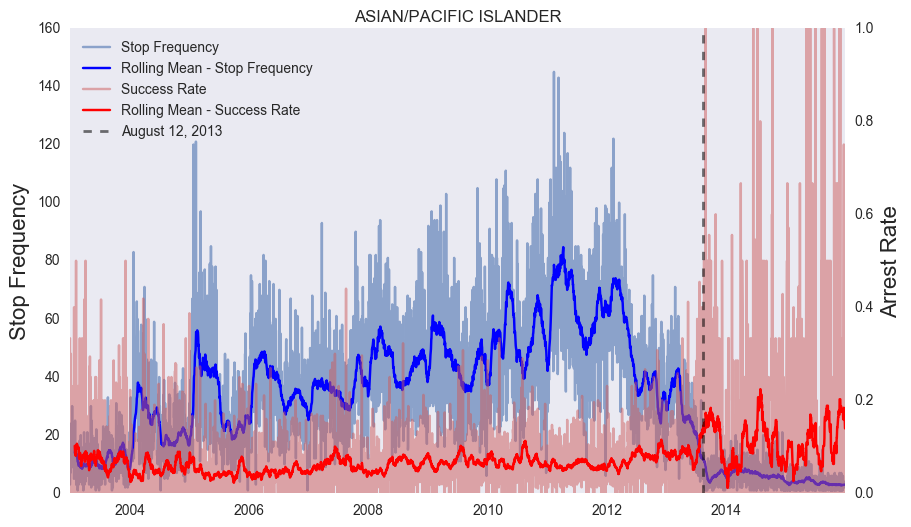

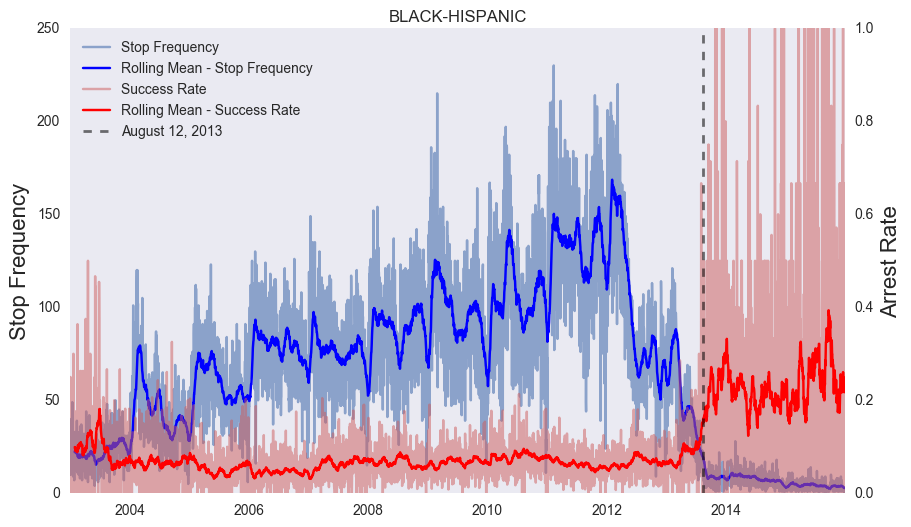

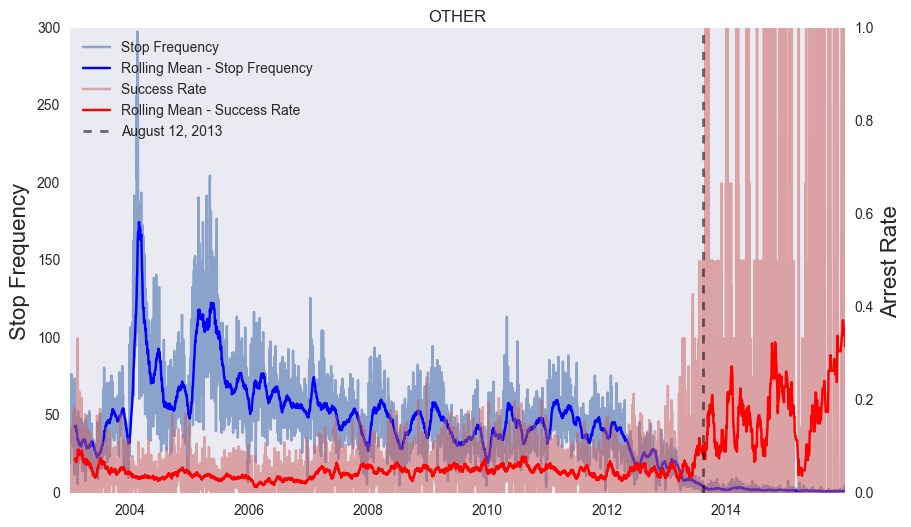

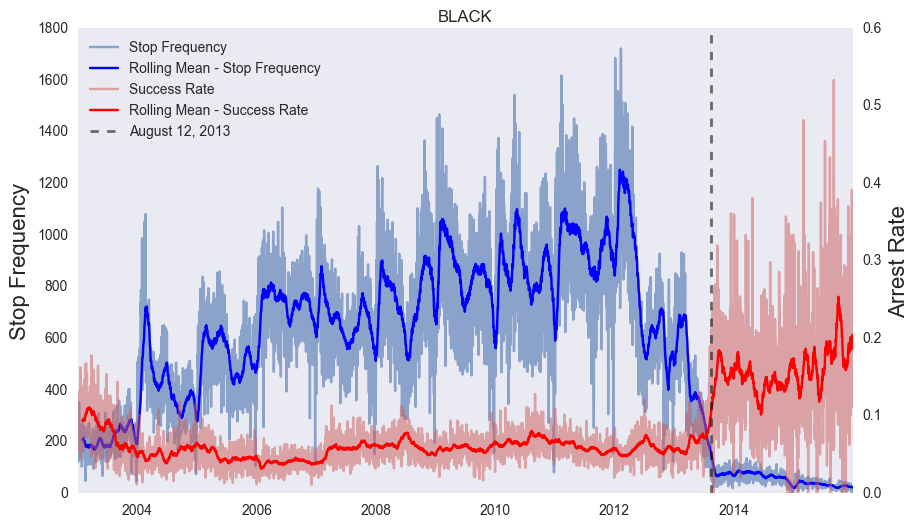

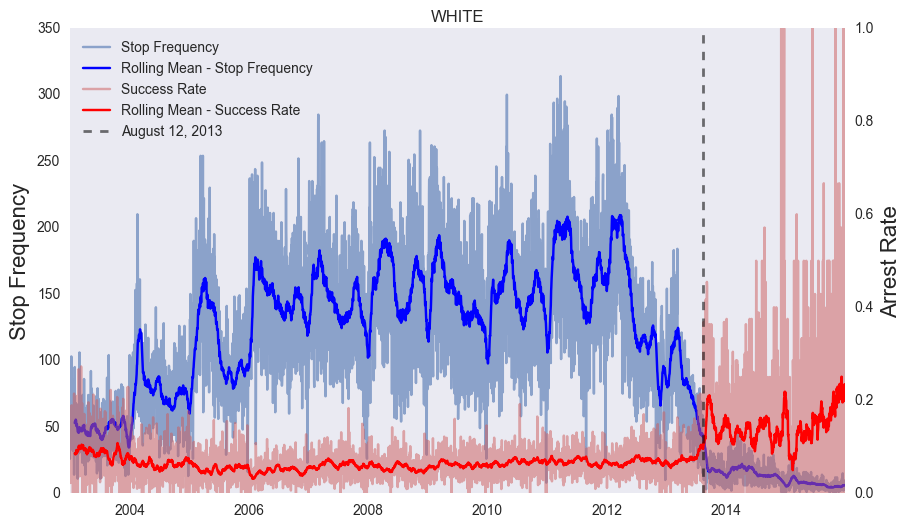

In [165]:
r = list(set(race_date_df['race']))
for idx, i in enumerate(r):
    temp = race_date_df[race_date_df['race'] == i]
    temp['RM_COUNT'] = pd.rolling_mean(temp.COUNT, window=30, min_periods=30)
    temp['RM_SUCCESS_RATE'] = pd.rolling_mean(temp.SUCCESS_RATE, window=30, min_periods=30)
    fig = plt.figure(figsize=(10,6))
#         ax.set_title(r[idx-1])
    ax = fig.add_subplot(111)
    lns1 = ax.plot(pd.to_datetime(temp['datestop']), temp['COUNT'], alpha=0.6, label='Stop Frequency')
    lns2 = ax.plot(pd.to_datetime(temp['datestop']), temp['RM_COUNT'], c='b', label='Rolling Mean - Stop Frequency')
    #ax.plot(0, 0, '-r', label = 'Rolling Mean - Success Rate')
    ax.grid(False)

    ax2 = ax.twinx()
    lns3 = ax2.plot(pd.to_datetime(temp['datestop']), temp['SUCCESS_RATE'], alpha=0.5, c='IndianRed', label = 'Success Rate')
    lns4 = ax2.plot(pd.to_datetime(temp['datestop']), temp['RM_SUCCESS_RATE'], c='r', label = 'Rolling Mean - Success Rate')
    lns5 = ax2.axvline(x=pd.to_datetime('2013-08-12'), ymin=0, ymax = 1, ls='dashed', alpha=0.55, linewidth=2, color='k', label='August 12, 2013')
    #ax2.set_ylim(-0.05, 1.05)

    lns = lns1+lns2+lns3+lns4
    lns.append(lns5)
    labs = [l.get_label() for l in lns]
    
    if idx==0:
        ax.legend(lns, labs, loc=9)
    else:
        ax.legend(lns, labs, loc=2)
    ax.set_title(r[idx])
    ax.set_ylabel('Stop Frequency', size=16)

    ax2.set_ylabel('Arrest Rate', size=16)
    ax2.grid(False)

    
#print temp.loc[:,['COUNT', 'SUCCESS_RATE']].corr()

In [ ]:
r = list(set(race_date_df['race']))
fig = plt.figure(figsize=(10,6))

print r
for idx, i in enumerate(r):
    print i
    temp = race_date_df[race_date_df['race'] == i]
    temp['RM_COUNT'] = pd.rolling_mean(temp.COUNT, window=30, min_periods=30)
    temp['RM_SUCCESS_RATE'] = pd.rolling_mean(temp.SUCCESS_RATE, window=30, min_periods=30)
    ax = fig.add_subplot(111)
    ax.plot(pd.to_datetime(temp['datestop']), temp['RM_COUNT'])
    plt.axvline(x=pd.to_datetime('2013-08-12'), ymin=0, ymax = 1, linewidth=2, color='k')
#     ax.plot(pd.to_datetime(temp['datestop']), temp['RM_COUNT'], c='b', label='RM - Stop Frequency')
#     ax2 = ax.twinx()
#     ax2.plot(pd.to_datetime(temp['datestop']), temp['SUCCESS_RATE'], alpha=0.5, c='IndianRed', label = 'temp')
#     ax2.plot(pd.to_datetime(temp['datestop']), temp['RM_SUCCESS_RATE'], c='r', label = 'temp')
#     ax2.set_ylim(min(temp['SUCCESS_RATE'])-0.05, max(temp['SUCCESS_RATE'])-0.05)

In [43]:
a = []
b = -1
for i in range(4748):
    if i%7 == 0:
        b += 1
    a.append(b)

In [44]:
date_df['week'] = a


In [45]:
len(date_df)

4748

In [46]:
date_df['weekday'] = pd.to_datetime(date_df.datestop).dt.dayofweek
th_fr_df = date_df[date_df['weekday'].isin([4,3])]
not_th_fr_df = date_df[~date_df['weekday'].isin([4,3])]

In [47]:
not_th_fr_df = not_th_fr_df.groupby('week').mean()
th_fr_df = th_fr_df.groupby('week').mean()

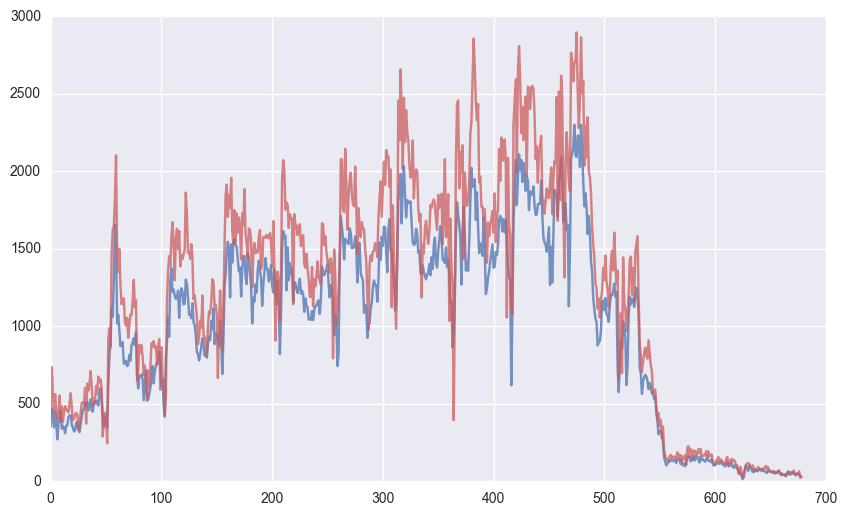

In [81]:
plt.figure(figsize=(10,6))
plt.plot(not_th_fr_df['COUNT'], alpha=0.75)
plt.plot(th_fr_df['COUNT'], alpha=0.75, color='IndianRed')

In [62]:
sample1 = not_th_fr_df['SUCCESS_RATE']
sample2 = th_fr_df['SUCCESS_RATE']
t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)

In [63]:
p_val

0.43147366421679956

In [64]:
sample1 = not_th_fr_df['COUNT']
sample2 = th_fr_df['COUNT']
t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)

In [65]:
p_val

7.5879826815711184e-09

In [76]:
sample = pd.merge(not_th_fr_df, th_fr_df, left_index=True, right_index=True, how='left')

In [121]:
sample['Diff'] = sample['COUNT_y'] - sample['COUNT_x']

In [122]:
mean(sample['Diff'])

212.60736377025057

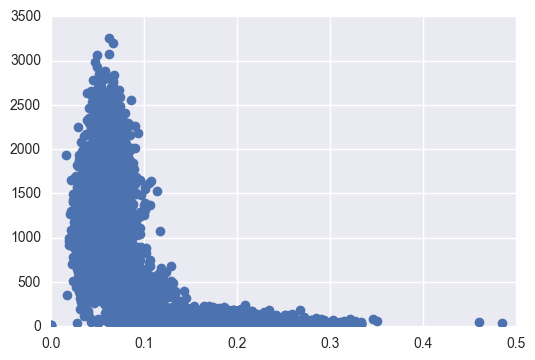

In [173]:
plt.plot(date_df['SUCCESS_RATE'], date_df['COUNT'], 'o' )